In [1]:
import keras
from keras import layers
from keras import ops

import matplotlib.pyplot as plt

In [3]:
num_classes = 8
input_shape = (256, 256, 3)
weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1
validation_split = 0.2
batch_size = 32
num_epochs = 50
patch_size = 16  # Size of the patches to be extracted from the input images.
num_patches = (input_shape[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 8
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 16 X 16 = 256 
Patches per image: 256


In [3]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, x):
        B, C = ops.shape(x)[0], ops.shape(x)[-1]
        x = ops.image.extract_patches(x, self.patch_size)
        x = ops.reshape(x, (B, -1, self.patch_size * self.patch_size * C))
        return x


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = ops.arange(start=0, stop=self.num_patch, step=1)
        return self.proj(patch) + self.pos_embed(pos)

In [4]:
def external_attention(
    x,
    dim,
    num_heads,
    dim_coefficient=4,
    attention_dropout=0,
    projection_dropout=0,
):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = ops.reshape(x, (-1, num_patch, num_heads, dim * dim_coefficient // num_heads))
    x = ops.transpose(x, axes=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = layers.Lambda(
        lambda attn: ops.divide(
            attn,
            ops.convert_to_tensor(1e-9) + ops.sum(attn, axis=-1, keepdims=True),
        )
    )(attn)
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = ops.transpose(x, axes=[0, 2, 1, 3])
    x = ops.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

In [5]:
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=ops.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

In [6]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=attention_dropout,
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x

In [7]:
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=input_shape)
    # Image augment
    #x = data_augmentation(inputs)
    # Extract patches.
    x = PatchExtract(patch_size)(inputs)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [8]:
model = get_model(attention_type="self_attention")
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_extract       │ (None, None, 768) │          0 │ input_layer[0][0] │
│ (PatchExtract)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding     │ (None, 256, 64)   │     65,600 │ patch_extract[0]… │
│ (PatchEmbedding)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 256, 64)   │        128 │ patch_embedding[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 64)   │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256, 64)   │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 64)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256, 64)   │      4,160 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256, 64)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256, 64)   │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 64)   │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256, 64)   │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256, 64)   │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256, 64)   │      4,160 │ dropout_4[0][0] 

 Total params: 1,196,104 (4.56 MB)

 Trainable params: 1,196,104 (4.56 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_path = '/kaggle/input/cotton-leaf-diseases-detection/train'
val_path = '/kaggle/input/cotton-leaf-diseases-detection/test'
train_gen = ImageDataGenerator(rescale=1./255)  
train_set = train_gen.flow_from_directory(train_path,
                                          target_size=(input_shape[0],input_shape[0]),
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          color_mode='rgb') 

val_gen = ImageDataGenerator(rescale=1./255)  
val_set = val_gen.flow_from_directory(val_path,
                                          target_size=(input_shape[0], input_shape[0]),
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          color_mode='rgb')

Found 3200 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


In [11]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger

model_path = os.path.join("files", "cotton.keras")
#csv_path = os.path.join("files", "logs.csv")

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-10, verbose=1),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    CSVLogger('EA_logs.csv', append=True)  # Add CSVLogger
]


history = model.fit(train_set,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=val_set,
    callbacks=callbacks
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732902688.488175     105 service.cc:145] XLA service 0x79408c01ea00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732902688.488230     105 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732902688.488234     105 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732902747.214252     105 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_31', 136 bytes spill stores, 136 bytes spill loads

I0000 00:00:1732902747.2

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.1760 - loss: 3.2355 - top-5-accuracy: 0.6950


KeyboardInterrupt



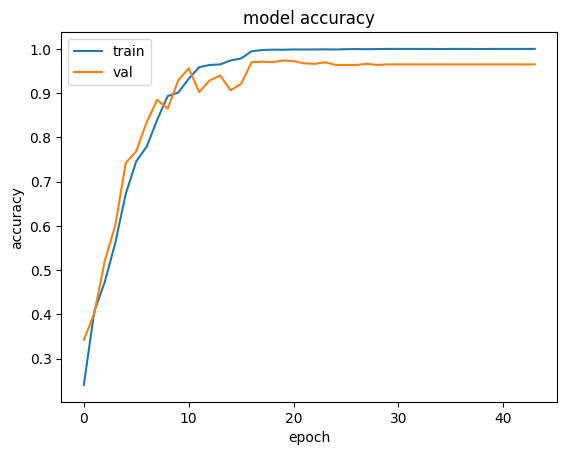

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('EA_model_accuracy.png')
plt.show()

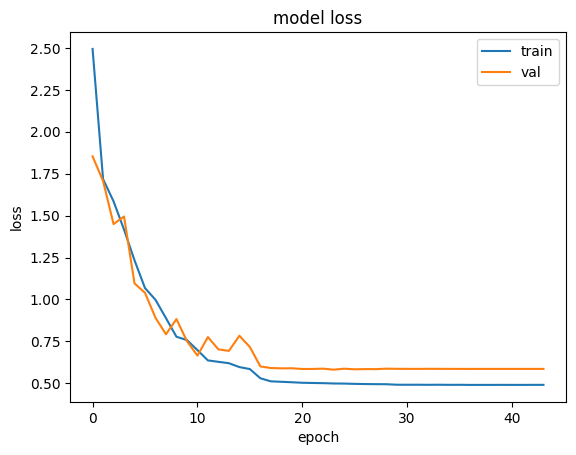

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig('EA_model_loss.png')
plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Load the model
model_path = '/kaggle/input/all-models-cotton/Models/EA256x16(main)cotton.keras'
model = load_model(model_path)

# Load the test data
test_dir = '/kaggle/input/cotton-leaf-diseases-detection/val'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(input_shape[0], input_shape[0]),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# Make predictions
predictions = model.predict(test_generator)
predicted_class_indices = np.argmax(predictions, axis=1)
# Map the predicted indices to the class labels
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_classes = [labels[k] for k in predicted_class_indices]

# List the filenames
filenames = test_generator.filenames

# Assuming true labels are available in the test set directories
true_labels = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_class_indices)

TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'functional_3', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 256, 256, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_1'}, 'registered_name': None, 'name': 'input_layer_1', 'inbound_nodes': []}, {'module': None, 'class_name': 'PatchExtract', 'config': {'name': 'patch_extract_1', 'patch_size': 16, 'trainable': True, 'dtype': 'float32'}, 'registered_name': 'PatchExtract', 'build_config': {'input_shape': [None, 256, 256, 3]}, 'name': 'patch_extract_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256, 3], 'dtype': 'float32', 'keras_history': ['input_layer_1', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'PatchEmbedding', 'config': {'name': 'patch_embedding_1', 'num_patch': 256, 'embed_dim': 64, 'trainable': True, 'dtype': 'float32'}, 'registered_name': 'PatchEmbedding', 'build_config': {'input_shape': [None, None, 768]}, 'name': 'patch_embedding_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, None, 768], 'dtype': 'float32', 'keras_history': ['patch_extract_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_16', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'layer_normalization_16', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['patch_embedding_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_51', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_51', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_16', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Reshape', 'config': {'newshape': [-1, 256, 32, 8]}, 'registered_name': 'Reshape', 'name': 'reshape_16', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256], 'dtype': 'float32', 'keras_history': ['dense_51', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Transpose', 'config': {'axes': [0, 2, 1, 3]}, 'registered_name': 'Transpose', 'name': 'transpose_16', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 32, 8], 'dtype': 'float32', 'keras_history': ['reshape_16', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_52', 'trainable': True, 'dtype': 'float32', 'units': 16, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 8]}, 'name': 'dense_52', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 8], 'dtype': 'float32', 'keras_history': ['transpose_16', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Softmax', 'config': {'name': 'softmax_8', 'trainable': True, 'dtype': 'float32', 'axis': 2}, 'registered_name': None, 'name': 'softmax_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['dense_52', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Lambda', 'config': {'name': 'lambda_8', 'trainable': True, 'dtype': 'float32', 'function': {'class_name': '__lambda__', 'config': {'code': '4wEAAAAAAAAAAAAAAAEAAAAJAAAAUwAAAHMiAAAAdACgAXwAdACgAmQBoQF0AGoDfABkAmQDZASN\nAxcAoQJTACkFTmeV1iboCy4RPun/////VCkC2gRheGlz2ghrZWVwZGltcykE2gNvcHPaBmRpdmlk\nZdoRY29udmVydF90b190ZW5zb3LaA3N1bSkB2gRhdHRuqQByCQAAAPofL3RtcC9pcHlrZXJuZWxf\nMzYvMjE5NDc4MTY0MS5wedoIPGxhbWJkYT4XAAAAcwgAAAAEAAIBGAEE/g==\n', 'defaults': None, 'closure': None}}, 'arguments': {}}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'lambda_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['softmax_8', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_32', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'dropout_32', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['lambda_8', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_53', 'trainable': True, 'dtype': 'float32', 'units': 8, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'dense_53', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['dropout_32', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Transpose', 'config': {'axes': [0, 2, 1, 3]}, 'registered_name': 'Transpose', 'name': 'transpose_17', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 8], 'dtype': 'float32', 'keras_history': ['dense_53', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Reshape', 'config': {'newshape': [-1, 256, 256]}, 'registered_name': 'Reshape', 'name': 'reshape_17', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 32, 8], 'dtype': 'float32', 'keras_history': ['transpose_17', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_54', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256]}, 'name': 'dense_54', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256], 'dtype': 'float32', 'keras_history': ['reshape_17', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_33', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_33', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_54', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_16', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 256, 64], [None, 256, 64]]}, 'name': 'add_16', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_33', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['patch_embedding_1', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_17', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'layer_normalization_17', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_16', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_55', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'gelu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_55', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_17', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_34', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_34', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_55', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_56', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_56', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_34', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_35', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_35', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_56', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_17', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 256, 64], [None, 256, 64]]}, 'name': 'add_17', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_35', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_16', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_18', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'layer_normalization_18', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_17', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_57', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_57', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_18', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Reshape', 'config': {'newshape': [-1, 256, 32, 8]}, 'registered_name': 'Reshape', 'name': 'reshape_18', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256], 'dtype': 'float32', 'keras_history': ['dense_57', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Transpose', 'config': {'axes': [0, 2, 1, 3]}, 'registered_name': 'Transpose', 'name': 'transpose_18', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 32, 8], 'dtype': 'float32', 'keras_history': ['reshape_18', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_58', 'trainable': True, 'dtype': 'float32', 'units': 16, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 8]}, 'name': 'dense_58', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 8], 'dtype': 'float32', 'keras_history': ['transpose_18', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Softmax', 'config': {'name': 'softmax_9', 'trainable': True, 'dtype': 'float32', 'axis': 2}, 'registered_name': None, 'name': 'softmax_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['dense_58', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Lambda', 'config': {'name': 'lambda_9', 'trainable': True, 'dtype': 'float32', 'function': {'class_name': '__lambda__', 'config': {'code': '4wEAAAAAAAAAAAAAAAEAAAAJAAAAUwAAAHMiAAAAdACgAXwAdACgAmQBoQF0AGoDfABkAmQDZASN\nAxcAoQJTACkFTmeV1iboCy4RPun/////VCkC2gRheGlz2ghrZWVwZGltcykE2gNvcHPaBmRpdmlk\nZdoRY29udmVydF90b190ZW5zb3LaA3N1bSkB2gRhdHRuqQByCQAAAPofL3RtcC9pcHlrZXJuZWxf\nMzYvMjE5NDc4MTY0MS5wedoIPGxhbWJkYT4XAAAAcwgAAAAEAAIBGAEE/g==\n', 'defaults': None, 'closure': None}}, 'arguments': {}}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'lambda_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['softmax_9', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_36', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'dropout_36', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['lambda_9', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_59', 'trainable': True, 'dtype': 'float32', 'units': 8, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'dense_59', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['dropout_36', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Transpose', 'config': {'axes': [0, 2, 1, 3]}, 'registered_name': 'Transpose', 'name': 'transpose_19', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 8], 'dtype': 'float32', 'keras_history': ['dense_59', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Reshape', 'config': {'newshape': [-1, 256, 256]}, 'registered_name': 'Reshape', 'name': 'reshape_19', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 32, 8], 'dtype': 'float32', 'keras_history': ['transpose_19', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_60', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256]}, 'name': 'dense_60', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256], 'dtype': 'float32', 'keras_history': ['reshape_19', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_37', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_37', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_60', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_18', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 256, 64], [None, 256, 64]]}, 'name': 'add_18', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_37', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_17', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_19', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'layer_normalization_19', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_18', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_61', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'gelu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_61', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_19', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_38', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_38', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_61', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_62', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_62', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_38', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_39', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_39', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_62', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_19', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 256, 64], [None, 256, 64]]}, 'name': 'add_19', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_39', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_18', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_20', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'layer_normalization_20', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_19', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_63', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_63', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_20', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Reshape', 'config': {'newshape': [-1, 256, 32, 8]}, 'registered_name': 'Reshape', 'name': 'reshape_20', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256], 'dtype': 'float32', 'keras_history': ['dense_63', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Transpose', 'config': {'axes': [0, 2, 1, 3]}, 'registered_name': 'Transpose', 'name': 'transpose_20', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 32, 8], 'dtype': 'float32', 'keras_history': ['reshape_20', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_64', 'trainable': True, 'dtype': 'float32', 'units': 16, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 8]}, 'name': 'dense_64', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 8], 'dtype': 'float32', 'keras_history': ['transpose_20', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Softmax', 'config': {'name': 'softmax_10', 'trainable': True, 'dtype': 'float32', 'axis': 2}, 'registered_name': None, 'name': 'softmax_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['dense_64', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Lambda', 'config': {'name': 'lambda_10', 'trainable': True, 'dtype': 'float32', 'function': {'class_name': '__lambda__', 'config': {'code': '4wEAAAAAAAAAAAAAAAEAAAAJAAAAUwAAAHMiAAAAdACgAXwAdACgAmQBoQF0AGoDfABkAmQDZASN\nAxcAoQJTACkFTmeV1iboCy4RPun/////VCkC2gRheGlz2ghrZWVwZGltcykE2gNvcHPaBmRpdmlk\nZdoRY29udmVydF90b190ZW5zb3LaA3N1bSkB2gRhdHRuqQByCQAAAPofL3RtcC9pcHlrZXJuZWxf\nMzYvMjE5NDc4MTY0MS5wedoIPGxhbWJkYT4XAAAAcwgAAAAEAAIBGAEE/g==\n', 'defaults': None, 'closure': None}}, 'arguments': {}}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'lambda_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['softmax_10', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_40', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'dropout_40', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['lambda_10', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_65', 'trainable': True, 'dtype': 'float32', 'units': 8, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'dense_65', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['dropout_40', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Transpose', 'config': {'axes': [0, 2, 1, 3]}, 'registered_name': 'Transpose', 'name': 'transpose_21', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 8], 'dtype': 'float32', 'keras_history': ['dense_65', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Reshape', 'config': {'newshape': [-1, 256, 256]}, 'registered_name': 'Reshape', 'name': 'reshape_21', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 32, 8], 'dtype': 'float32', 'keras_history': ['transpose_21', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_66', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256]}, 'name': 'dense_66', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256], 'dtype': 'float32', 'keras_history': ['reshape_21', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_41', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_41', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_66', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_20', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 256, 64], [None, 256, 64]]}, 'name': 'add_20', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_41', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_19', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_21', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'layer_normalization_21', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_20', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_67', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'gelu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_67', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_21', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_42', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_42', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_67', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_68', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_68', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_42', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_43', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_43', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_68', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_21', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 256, 64], [None, 256, 64]]}, 'name': 'add_21', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_43', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_20', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_22', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'layer_normalization_22', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_21', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_69', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_69', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_22', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Reshape', 'config': {'newshape': [-1, 256, 32, 8]}, 'registered_name': 'Reshape', 'name': 'reshape_22', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256], 'dtype': 'float32', 'keras_history': ['dense_69', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Transpose', 'config': {'axes': [0, 2, 1, 3]}, 'registered_name': 'Transpose', 'name': 'transpose_22', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 32, 8], 'dtype': 'float32', 'keras_history': ['reshape_22', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_70', 'trainable': True, 'dtype': 'float32', 'units': 16, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 8]}, 'name': 'dense_70', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 8], 'dtype': 'float32', 'keras_history': ['transpose_22', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Softmax', 'config': {'name': 'softmax_11', 'trainable': True, 'dtype': 'float32', 'axis': 2}, 'registered_name': None, 'name': 'softmax_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['dense_70', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Lambda', 'config': {'name': 'lambda_11', 'trainable': True, 'dtype': 'float32', 'function': {'class_name': '__lambda__', 'config': {'code': '4wEAAAAAAAAAAAAAAAEAAAAJAAAAUwAAAHMiAAAAdACgAXwAdACgAmQBoQF0AGoDfABkAmQDZASN\nAxcAoQJTACkFTmeV1iboCy4RPun/////VCkC2gRheGlz2ghrZWVwZGltcykE2gNvcHPaBmRpdmlk\nZdoRY29udmVydF90b190ZW5zb3LaA3N1bSkB2gRhdHRuqQByCQAAAPofL3RtcC9pcHlrZXJuZWxf\nMzYvMjE5NDc4MTY0MS5wedoIPGxhbWJkYT4XAAAAcwgAAAAEAAIBGAEE/g==\n', 'defaults': None, 'closure': None}}, 'arguments': {}}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'lambda_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['softmax_11', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_44', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'dropout_44', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['lambda_11', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_71', 'trainable': True, 'dtype': 'float32', 'units': 8, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'dense_71', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['dropout_44', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Transpose', 'config': {'axes': [0, 2, 1, 3]}, 'registered_name': 'Transpose', 'name': 'transpose_23', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 8], 'dtype': 'float32', 'keras_history': ['dense_71', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Reshape', 'config': {'newshape': [-1, 256, 256]}, 'registered_name': 'Reshape', 'name': 'reshape_23', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 32, 8], 'dtype': 'float32', 'keras_history': ['transpose_23', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_72', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256]}, 'name': 'dense_72', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256], 'dtype': 'float32', 'keras_history': ['reshape_23', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_45', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_45', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_72', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_22', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 256, 64], [None, 256, 64]]}, 'name': 'add_22', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_45', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_21', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_23', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'layer_normalization_23', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_22', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_73', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'gelu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_73', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_23', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_46', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_46', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_73', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_74', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_74', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_46', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_47', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_47', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_74', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_23', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 256, 64], [None, 256, 64]]}, 'name': 'add_23', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_47', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_22', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_24', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'layer_normalization_24', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_23', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_75', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_75', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_24', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Reshape', 'config': {'newshape': [-1, 256, 32, 8]}, 'registered_name': 'Reshape', 'name': 'reshape_24', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256], 'dtype': 'float32', 'keras_history': ['dense_75', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Transpose', 'config': {'axes': [0, 2, 1, 3]}, 'registered_name': 'Transpose', 'name': 'transpose_24', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 32, 8], 'dtype': 'float32', 'keras_history': ['reshape_24', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_76', 'trainable': True, 'dtype': 'float32', 'units': 16, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 8]}, 'name': 'dense_76', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 8], 'dtype': 'float32', 'keras_history': ['transpose_24', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Softmax', 'config': {'name': 'softmax_12', 'trainable': True, 'dtype': 'float32', 'axis': 2}, 'registered_name': None, 'name': 'softmax_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['dense_76', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Lambda', 'config': {'name': 'lambda_12', 'trainable': True, 'dtype': 'float32', 'function': {'class_name': '__lambda__', 'config': {'code': '4wEAAAAAAAAAAAAAAAEAAAAJAAAAUwAAAHMiAAAAdACgAXwAdACgAmQBoQF0AGoDfABkAmQDZASN\nAxcAoQJTACkFTmeV1iboCy4RPun/////VCkC2gRheGlz2ghrZWVwZGltcykE2gNvcHPaBmRpdmlk\nZdoRY29udmVydF90b190ZW5zb3LaA3N1bSkB2gRhdHRuqQByCQAAAPofL3RtcC9pcHlrZXJuZWxf\nMzYvMjE5NDc4MTY0MS5wedoIPGxhbWJkYT4XAAAAcwgAAAAEAAIBGAEE/g==\n', 'defaults': None, 'closure': None}}, 'arguments': {}}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'lambda_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['softmax_12', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_48', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'dropout_48', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['lambda_12', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_77', 'trainable': True, 'dtype': 'float32', 'units': 8, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'dense_77', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['dropout_48', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Transpose', 'config': {'axes': [0, 2, 1, 3]}, 'registered_name': 'Transpose', 'name': 'transpose_25', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 8], 'dtype': 'float32', 'keras_history': ['dense_77', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Reshape', 'config': {'newshape': [-1, 256, 256]}, 'registered_name': 'Reshape', 'name': 'reshape_25', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 32, 8], 'dtype': 'float32', 'keras_history': ['transpose_25', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_78', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256]}, 'name': 'dense_78', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256], 'dtype': 'float32', 'keras_history': ['reshape_25', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_49', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_49', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_78', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_24', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 256, 64], [None, 256, 64]]}, 'name': 'add_24', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_49', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_23', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_25', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'layer_normalization_25', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_24', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_79', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'gelu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_79', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_25', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_50', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_50', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_79', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_80', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_80', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_50', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_51', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_51', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_80', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_25', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 256, 64], [None, 256, 64]]}, 'name': 'add_25', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_51', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_24', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_26', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'layer_normalization_26', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_25', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_81', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_81', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_26', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Reshape', 'config': {'newshape': [-1, 256, 32, 8]}, 'registered_name': 'Reshape', 'name': 'reshape_26', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256], 'dtype': 'float32', 'keras_history': ['dense_81', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Transpose', 'config': {'axes': [0, 2, 1, 3]}, 'registered_name': 'Transpose', 'name': 'transpose_26', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 32, 8], 'dtype': 'float32', 'keras_history': ['reshape_26', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_82', 'trainable': True, 'dtype': 'float32', 'units': 16, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 8]}, 'name': 'dense_82', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 8], 'dtype': 'float32', 'keras_history': ['transpose_26', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Softmax', 'config': {'name': 'softmax_13', 'trainable': True, 'dtype': 'float32', 'axis': 2}, 'registered_name': None, 'name': 'softmax_13', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['dense_82', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Lambda', 'config': {'name': 'lambda_13', 'trainable': True, 'dtype': 'float32', 'function': {'class_name': '__lambda__', 'config': {'code': '4wEAAAAAAAAAAAAAAAEAAAAJAAAAUwAAAHMiAAAAdACgAXwAdACgAmQBoQF0AGoDfABkAmQDZASN\nAxcAoQJTACkFTmeV1iboCy4RPun/////VCkC2gRheGlz2ghrZWVwZGltcykE2gNvcHPaBmRpdmlk\nZdoRY29udmVydF90b190ZW5zb3LaA3N1bSkB2gRhdHRuqQByCQAAAPofL3RtcC9pcHlrZXJuZWxf\nMzYvMjE5NDc4MTY0MS5wedoIPGxhbWJkYT4XAAAAcwgAAAAEAAIBGAEE/g==\n', 'defaults': None, 'closure': None}}, 'arguments': {}}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'lambda_13', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['softmax_13', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_52', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'dropout_52', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['lambda_13', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_83', 'trainable': True, 'dtype': 'float32', 'units': 8, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'dense_83', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['dropout_52', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Transpose', 'config': {'axes': [0, 2, 1, 3]}, 'registered_name': 'Transpose', 'name': 'transpose_27', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 8], 'dtype': 'float32', 'keras_history': ['dense_83', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Reshape', 'config': {'newshape': [-1, 256, 256]}, 'registered_name': 'Reshape', 'name': 'reshape_27', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 32, 8], 'dtype': 'float32', 'keras_history': ['transpose_27', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_84', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256]}, 'name': 'dense_84', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256], 'dtype': 'float32', 'keras_history': ['reshape_27', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_53', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_53', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_84', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_26', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 256, 64], [None, 256, 64]]}, 'name': 'add_26', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_53', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_25', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_27', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'layer_normalization_27', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_26', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_85', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'gelu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_85', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_27', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_54', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_54', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_85', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_86', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_86', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_54', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_55', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_55', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_86', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_27', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 256, 64], [None, 256, 64]]}, 'name': 'add_27', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_55', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_26', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_28', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'layer_normalization_28', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_27', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_87', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_87', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_28', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Reshape', 'config': {'newshape': [-1, 256, 32, 8]}, 'registered_name': 'Reshape', 'name': 'reshape_28', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256], 'dtype': 'float32', 'keras_history': ['dense_87', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Transpose', 'config': {'axes': [0, 2, 1, 3]}, 'registered_name': 'Transpose', 'name': 'transpose_28', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 32, 8], 'dtype': 'float32', 'keras_history': ['reshape_28', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_88', 'trainable': True, 'dtype': 'float32', 'units': 16, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 8]}, 'name': 'dense_88', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 8], 'dtype': 'float32', 'keras_history': ['transpose_28', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Softmax', 'config': {'name': 'softmax_14', 'trainable': True, 'dtype': 'float32', 'axis': 2}, 'registered_name': None, 'name': 'softmax_14', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['dense_88', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Lambda', 'config': {'name': 'lambda_14', 'trainable': True, 'dtype': 'float32', 'function': {'class_name': '__lambda__', 'config': {'code': '4wEAAAAAAAAAAAAAAAEAAAAJAAAAUwAAAHMiAAAAdACgAXwAdACgAmQBoQF0AGoDfABkAmQDZASN\nAxcAoQJTACkFTmeV1iboCy4RPun/////VCkC2gRheGlz2ghrZWVwZGltcykE2gNvcHPaBmRpdmlk\nZdoRY29udmVydF90b190ZW5zb3LaA3N1bSkB2gRhdHRuqQByCQAAAPofL3RtcC9pcHlrZXJuZWxf\nMzYvMjE5NDc4MTY0MS5wedoIPGxhbWJkYT4XAAAAcwgAAAAEAAIBGAEE/g==\n', 'defaults': None, 'closure': None}}, 'arguments': {}}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'lambda_14', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['softmax_14', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_56', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'dropout_56', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['lambda_14', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_89', 'trainable': True, 'dtype': 'float32', 'units': 8, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'dense_89', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['dropout_56', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Transpose', 'config': {'axes': [0, 2, 1, 3]}, 'registered_name': 'Transpose', 'name': 'transpose_29', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 8], 'dtype': 'float32', 'keras_history': ['dense_89', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Reshape', 'config': {'newshape': [-1, 256, 256]}, 'registered_name': 'Reshape', 'name': 'reshape_29', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 32, 8], 'dtype': 'float32', 'keras_history': ['transpose_29', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_90', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256]}, 'name': 'dense_90', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256], 'dtype': 'float32', 'keras_history': ['reshape_29', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_57', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_57', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_90', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_28', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 256, 64], [None, 256, 64]]}, 'name': 'add_28', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_57', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_27', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_29', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'layer_normalization_29', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_28', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_91', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'gelu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_91', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_29', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_58', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_58', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_91', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_92', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_92', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_58', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_59', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_59', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_92', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_29', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 256, 64], [None, 256, 64]]}, 'name': 'add_29', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_59', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_28', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_30', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'layer_normalization_30', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_29', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_93', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_93', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_30', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Reshape', 'config': {'newshape': [-1, 256, 32, 8]}, 'registered_name': 'Reshape', 'name': 'reshape_30', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256], 'dtype': 'float32', 'keras_history': ['dense_93', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Transpose', 'config': {'axes': [0, 2, 1, 3]}, 'registered_name': 'Transpose', 'name': 'transpose_30', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 32, 8], 'dtype': 'float32', 'keras_history': ['reshape_30', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_94', 'trainable': True, 'dtype': 'float32', 'units': 16, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 8]}, 'name': 'dense_94', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 8], 'dtype': 'float32', 'keras_history': ['transpose_30', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Softmax', 'config': {'name': 'softmax_15', 'trainable': True, 'dtype': 'float32', 'axis': 2}, 'registered_name': None, 'name': 'softmax_15', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['dense_94', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Lambda', 'config': {'name': 'lambda_15', 'trainable': True, 'dtype': 'float32', 'function': {'class_name': '__lambda__', 'config': {'code': '4wEAAAAAAAAAAAAAAAEAAAAJAAAAUwAAAHMiAAAAdACgAXwAdACgAmQBoQF0AGoDfABkAmQDZASN\nAxcAoQJTACkFTmeV1iboCy4RPun/////VCkC2gRheGlz2ghrZWVwZGltcykE2gNvcHPaBmRpdmlk\nZdoRY29udmVydF90b190ZW5zb3LaA3N1bSkB2gRhdHRuqQByCQAAAPofL3RtcC9pcHlrZXJuZWxf\nMzYvMjE5NDc4MTY0MS5wedoIPGxhbWJkYT4XAAAAcwgAAAAEAAIBGAEE/g==\n', 'defaults': None, 'closure': None}}, 'arguments': {}}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'lambda_15', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['softmax_15', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_60', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'dropout_60', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['lambda_15', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_95', 'trainable': True, 'dtype': 'float32', 'units': 8, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 256, 16]}, 'name': 'dense_95', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 16], 'dtype': 'float32', 'keras_history': ['dropout_60', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Transpose', 'config': {'axes': [0, 2, 1, 3]}, 'registered_name': 'Transpose', 'name': 'transpose_31', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 256, 8], 'dtype': 'float32', 'keras_history': ['dense_95', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Reshape', 'config': {'newshape': [-1, 256, 256]}, 'registered_name': 'Reshape', 'name': 'reshape_31', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 32, 8], 'dtype': 'float32', 'keras_history': ['transpose_31', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_96', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256]}, 'name': 'dense_96', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256], 'dtype': 'float32', 'keras_history': ['reshape_31', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_61', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_61', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_96', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_30', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 256, 64], [None, 256, 64]]}, 'name': 'add_30', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_61', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_29', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_31', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-05, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'layer_normalization_31', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_30', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_97', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'gelu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_97', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_31', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_62', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_62', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_97', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_98', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dense_98', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_62', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_63', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'dropout_63', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dense_98', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_31', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 256, 64], [None, 256, 64]]}, 'name': 'add_31', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['dropout_63', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_30', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling1D', 'config': {'name': 'global_average_pooling1d_1', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 64]}, 'name': 'global_average_pooling1d_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 64], 'dtype': 'float32', 'keras_history': ['add_31', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_99', 'trainable': True, 'dtype': 'float32', 'units': 8, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64]}, 'name': 'dense_99', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64], 'dtype': 'float32', 'keras_history': ['global_average_pooling1d_1', 0, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer_1', 0, 0]], 'output_layers': [['dense_99', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'AdamW', 'config': {'name': 'adamw', 'learning_rate': 0.00010000000474974513, 'weight_decay': 0.0001, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': {'module': 'keras.losses', 'class_name': 'CategoricalCrossentropy', 'config': {'name': 'categorical_crossentropy', 'reduction': 'sum_over_batch_size', 'from_logits': False, 'label_smoothing': 0.1, 'axis': -1}, 'registered_name': None}, 'loss_weights': None, 'metrics': [{'module': 'keras.metrics', 'class_name': 'CategoricalAccuracy', 'config': {'name': 'accuracy', 'dtype': 'float32'}, 'registered_name': None}, {'module': 'keras.metrics', 'class_name': 'TopKCategoricalAccuracy', 'config': {'name': 'top-5-accuracy', 'dtype': 'float32', 'k': 5}, 'registered_name': None}], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: Could not locate class 'PatchExtract'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'PatchExtract', 'config': {'name': 'patch_extract_1', 'patch_size': 16, 'trainable': True, 'dtype': 'float32'}, 'registered_name': 'PatchExtract', 'build_config': {'input_shape': [None, 256, 256, 3]}, 'name': 'patch_extract_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256, 3], 'dtype': 'float32', 'keras_history': ['input_layer_1', 0, 0]}}], 'kwargs': {}}]}

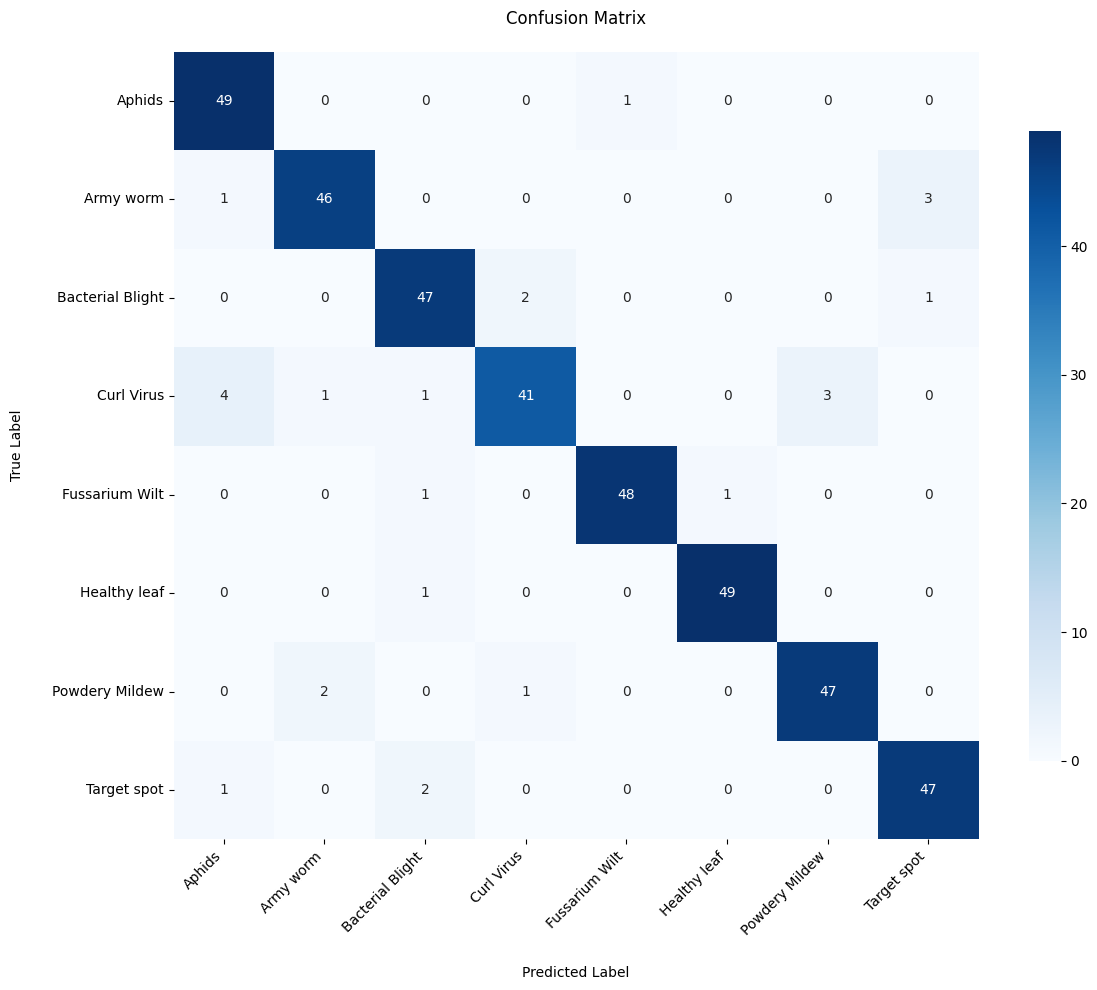

In [16]:
# Plot the heatmap for the confusion matrix
# Plot the heatmap for the confusion matrix
plt.figure(figsize=(12, 10))  # Adjusted size for more space
ax = sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=list(labels.values()), 
    yticklabels=list(labels.values()), 
    cbar_kws={'shrink': 0.8},
    annot_kws={"size": 12}  # Adjust font size of annotations
)

# Rotate the labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)  # Adjust tick font size
plt.yticks(rotation=0, fontsize=12)               # Adjust tick font size

# Add title and axis labels
plt.title('Confusion Matrix', pad=20, fontsize=16)  # Adjust title font size
plt.xlabel('Predicted Label', labelpad=20, fontsize=14)  # Adjust label font size
plt.ylabel('True Label', labelpad=20, fontsize=14)      # Adjust label font size

# Adjust the layout to prevent cropping
plt.tight_layout()

# Save the heatmap
plt.savefig('VGG16_cm.png')

# Show the plot
plt.show()



In [17]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Assuming true_labels and predicted_class_indices are your actual and predicted labels

# Accuracy
accuracy = accuracy_score(true_labels, predicted_class_indices)
print(f'Accuracy: {accuracy:.4f}')

# For multiclass classification, use an appropriate average (e.g., 'macro', 'micro', or 'weighted')

# Recall
recall = recall_score(true_labels, predicted_class_indices, average='macro')  # Change 'macro' to your preference
print(f'Recall: {recall:.4f}')

# Precision
precision = precision_score(true_labels, predicted_class_indices, average='macro')
print(f'Precision: {precision:.4f}')

# F1 Score
f1 = f1_score(true_labels, predicted_class_indices, average='macro')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.9350
Recall: 0.9350
Precision: 0.9358
F1 Score: 0.9346


In [18]:
def load_image_from_folder(image_path):
    img = load_img(image_path, target_size=input_shape[:2])  # Resize image to the input shape
    img = img_to_array(img)  # Convert image to array
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Specify the image path
image_path = '/kaggle/input/cotton-leaf-diseases-detection/test/Aphids/1.jpg'  # Replace with the actual path to your image


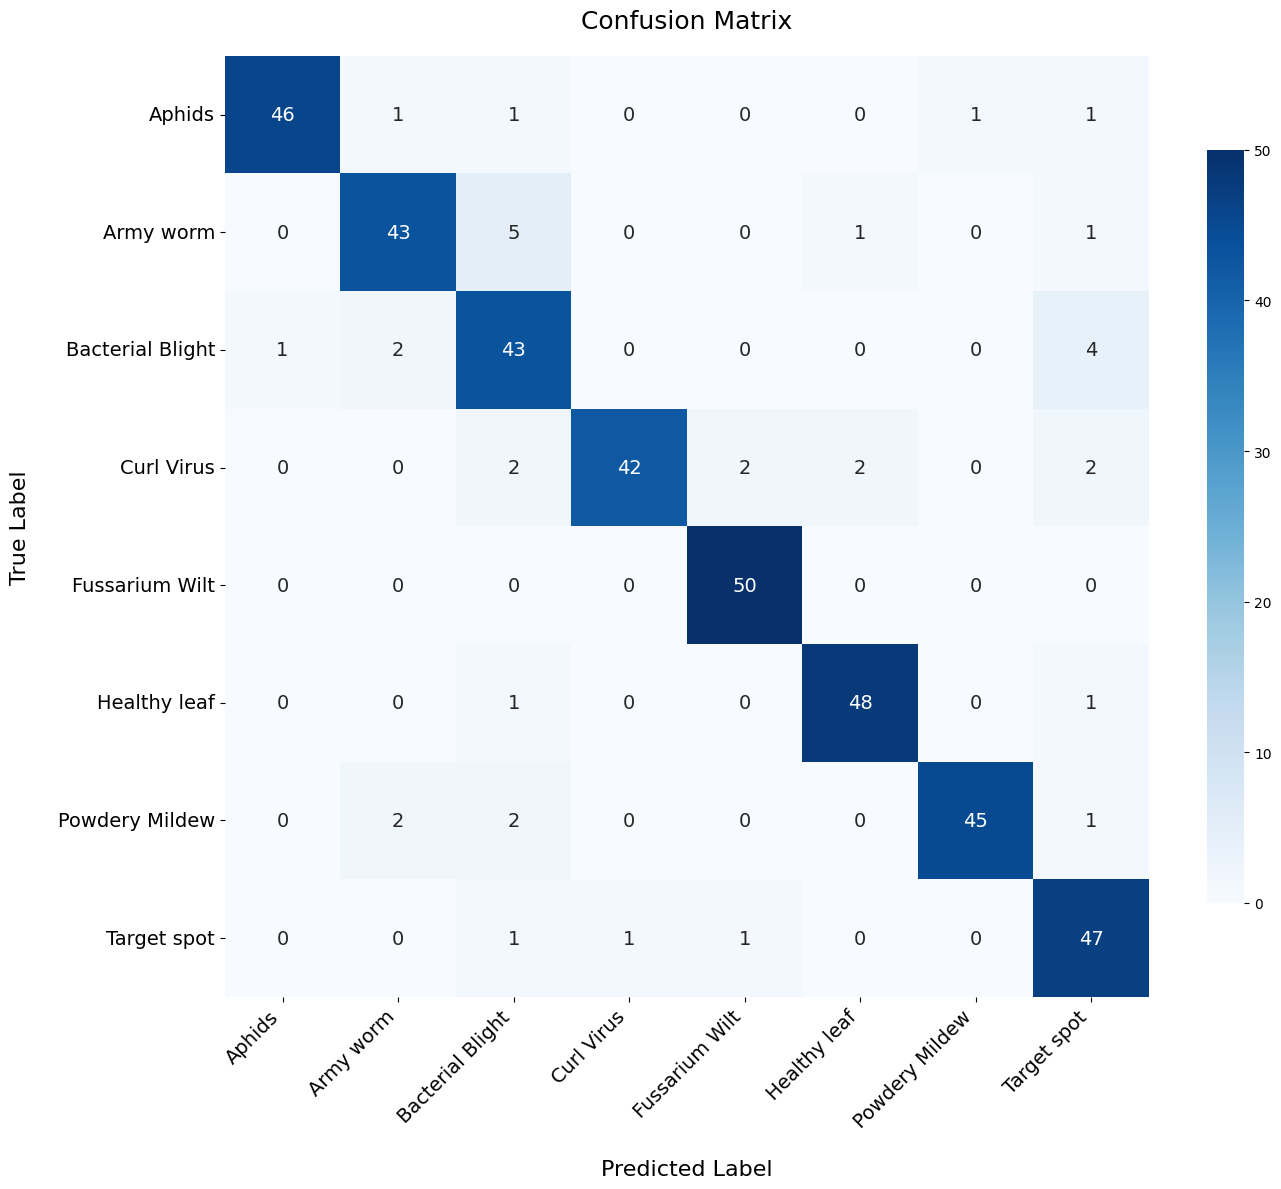

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example confusion matrix for visualization (you can replace with your actual confusion matrix)
cm = np.array([
    [46, 1, 1, 0, 0, 0, 1, 1],
    [0, 43, 5, 0, 0, 1, 0, 1],
    [1, 2, 43, 0, 0, 0, 0, 4],
    [0, 0, 2, 42, 2, 2, 0, 2],
    [0, 0, 0, 0, 50, 0, 0, 0],
    [0, 0, 1, 0, 0, 48, 0, 1],
    [0, 2, 2, 0, 0, 0, 45, 1],
    [0, 0, 1, 1, 1, 0, 0, 47]
])

# Class labels for the confusion matrix
class_labels = ['Aphids', 'Army worm', 'Bacterial Blight', 'Curl Virus', 
                'Fussarium Wilt', 'Healthy leaf', 'Powdery Mildew', 'Target spot']

# Plot the heatmap
plt.figure(figsize=(14, 12))  # Adjusted size for more space
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels,
    cbar_kws={'shrink': 0.8},
    annot_kws={"size": 14}  # Adjust font size of annotations
)

# Rotate and resize labels
plt.xticks(rotation=45, ha='right', fontsize=14)  # Adjust x-tick font size
plt.yticks(rotation=0, fontsize=14)              # Adjust y-tick font size

# Add title and axis labels
plt.title('Confusion Matrix', pad=20, fontsize=18)       # Increase title font size
plt.xlabel('Predicted Label', labelpad=20, fontsize=16)  # Increase x-axis label font size
plt.ylabel('True Label', labelpad=20, fontsize=16)       # Increase y-axis label font size

# Adjust layout
plt.tight_layout()

# Save the heatmap as a PNG
plt.savefig('/mnt/data/Updated_EA_4_cm.png', dpi=300)

# Show the plot
plt.show()
